In [1]:
import sys
sys.path.append("../utils/")

In [2]:
from backend_manager import BackendManager
from runner import Runner
from data_collector import DataCollector
from filter_on_kpis import FilterOnKPIs
from runner_competing import RunnerCompeting
from case_duration_manager import CaseDurationsManager
from rank_variants import RankVariants
from measurements_visualizer import MeasurementsVisualizer
from measure_and_rank import measure_and_rank

In [3]:
import os
import time
import shutil

#### 01. Backend -NA

In [4]:
# submit_cmd = "sbatch submit.sh"
# #bm = BackendManager("login18-1.hpc.itc.rwth-aachen.de", "as641651", submit_cmd)
# bm = BackendManager("login18-1.hpc.itc.rwth-aachen.de", "as641651")
# bm.connect()
bm = None

#### 02. Runner

In [5]:
args = ["75","75","8","75","75"]

exp_dir = "../Matrix-Chain-4/variants-linnea/"
if bm:
    exp_dir = "~/PhD/performance-analyazer/Experiment2/Matrix-Chain-4/variants-linnea"
threads = 4
runner = Runner("MC", exp_dir, args, threads=threads, backend=bm)

#### 03. Job name - NA

In [6]:
if bm:
    args_dir_name = runner.args_dir.split('/')[-1]
    job_name = "{}_T{}".format(args_dir_name, threads)
    job_name

#### 04. DataCollector

In [7]:
if bm:
    exp_dir_local = "../Matrix-Chain-4/variants-linnea/"
    local_data_dir = os.path.join(exp_dir_local, "cluster-experiments", "{}".format(args_dir_name))
    if os.path.exists(local_data_dir):
        shutil.rmtree(local_data_dir)
    os.makedirs(local_data_dir)
    dc = DataCollector(local_data_dir, runner.args_dir, bm)
else:
    dc = DataCollector(runner.args_dir)

#### 05. Look for already available data

In [8]:
case_table = dc.get_case_table()
case_table

,case:concept:name,case:flops,case:num_kernels
0,algorithm1,270000.0,3
1,algorithm5,1780000.0,3
2,algorithm4,1780000.0,3
3,algorithm0,270000.0,3
4,algorithm3,1020000.0,3
5,algorithm2,1020000.0,3


In [9]:
cm = CaseDurationsManager()
cm.collect_case_durations(dc)

Collected data from 9 runs


In [10]:
#cm.case_durations.head()

#### 05. Generate Experiments

In [11]:
ret = runner.generate_experiments()
ret

New solution:..............2.7e+05
No further generation steps possible.
----------------------------------
Number of nodes:                 8
Solution nodes:                  1
Data:                     1.81e+04
Best solution:             2.7e+05
Intensity:                    14.9
Number of algorithms:            6
Generated Variants.


0

#### 06. Single-run Experiment

In [12]:
ret = runner.run_experiments()
ret

Running Experiments locally
Experiments completed locally


0

In [13]:
if bm:
    while bm.check_slrum_status(job_name) != 0:
        print("Waiting for Job to complete.")
        time.sleep(5)

In [14]:
case_table = dc.get_case_table()
measurements = dc.get_all_runtimes_table()

In [15]:
case_table

,case:concept:name,case:flops,case:num_kernels
0,algorithm1,270000.0,3
1,algorithm5,1780000.0,3
2,algorithm4,1780000.0,3
3,algorithm0,270000.0,3
4,algorithm3,1020000.0,3
5,algorithm2,1020000.0,3


In [16]:
measurements.head()

,case:concept:name,concept:name,concept:flops,concept:operation,concept:kernel,timestamp:start,timestamp:end
0,algorithm1,gemm_9e+04,90000.0,tmp1 = (A B),"gemm!('N', 'N', 1.0, ml0, ml1, 0.0, ml4)",1.657006e+09,1.657006e+09
1,algorithm1,gemm_9e+04,90000.0,tmp3 = (C D),"gemm!('N', 'N', 1.0, ml2, ml3, 0.0, ml5)",1.657006e+09,1.657006e+09
2,algorithm1,gemm_9e+04,90000.0,tmp6 = (tmp1 tmp3),"gemm!('N', 'N', 1.0, ml4, ml5, 0.0, ml6)",1.657006e+09,1.657006e+09
3,algorithm5,gemm_9e+04,90000.0,tmp2 = (B C),"gemm!('N', 'N', 1.0, ml1, ml2, 0.0, ml4)",1.657006e+09,1.657006e+09
4,algorithm5,gemm_8.44e+05,844000.0,tmp4 = (A tmp2),"gemm!('N', 'N', 1.0, ml0, ml4, 0.0, ml5)",1.657006e+09,1.657006e+09


#### 07. KPI filter

In [17]:
kpi_filter = FilterOnKPIs(case_table, measurements)
kpi_filter.case_table

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration,case:flops,case:num_kernels,case:rel-flops,case:rel-duration
0,algorithm1,1.657006e+09,1.657006e+09,0.000040,270000.0,3,0.000000,0.000000
1,algorithm5,1.657006e+09,1.657006e+09,0.000105,1780000.0,3,5.592593,1.625000
2,algorithm4,1.657006e+09,1.657006e+09,0.000128,1780000.0,3,5.592593,2.196429
3,algorithm0,1.657006e+09,1.657006e+09,0.000041,270000.0,3,0.000000,0.023810
4,algorithm3,1.657006e+09,1.657006e+09,0.000114,1020000.0,3,2.777778,1.845238
5,algorithm2,1.657006e+09,1.657006e+09,0.000175,1020000.0,3,2.777778,3.369048


In [20]:
competing_cases = kpi_filter.filter_on_flops_and_rel_duration(3)
competing_cases

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration,case:flops,case:num_kernels,case:rel-flops,case:rel-duration
0,algorithm1,1.657006e+09,1.657006e+09,0.000040,270000.0,3,0.000000,0.000000
1,algorithm5,1.657006e+09,1.657006e+09,0.000105,1780000.0,3,5.592593,1.625000
2,algorithm4,1.657006e+09,1.657006e+09,0.000128,1780000.0,3,5.592593,2.196429
3,algorithm0,1.657006e+09,1.657006e+09,0.000041,270000.0,3,0.000000,0.023810
4,algorithm3,1.657006e+09,1.657006e+09,0.000114,1020000.0,3,2.777778,1.845238


In [21]:
alg_seq_h0 = kpi_filter.get_alg_seq_sorted_on_duration(competing_cases)
alg_seq_h0

['algorithm1', 'algorithm0', 'algorithm5', 'algorithm3', 'algorithm4']

#### 08. Runner Competing and compute ranks

In [22]:
runner_competing = RunnerCompeting(alg_seq_h0, runner.args_dir,
                                          threads=threads, backend=bm)

In [23]:
# Clear previous measurements if available before re-running
dc.delete_competing_measurements()
dc.delete_ranks()

rep_steps = 3
eps=0.001
max_rep = 30
ret = runner_competing.compute_ranks(rep_steps=rep_steps, eps=eps,max_rep=max_rep)
ret

Running experiments locally.
Experiments completed locally
  case:concept:name  case:mean-rank
0        algorithm0        0.000000
1        algorithm1        1.000000
2        algorithm3        2.000000
3        algorithm5        2.000000
4        algorithm4        2.142857
norm: 0.705662230584484
Running experiments locally.
Experiments completed locally
  case:concept:name  case:mean-rank
0        algorithm0        0.000000
1        algorithm1        0.571429
2        algorithm3        1.571429
3        algorithm5        2.571429
4        algorithm4        2.571429
norm: 0.21946130708196027
Running experiments locally.
Experiments completed locally
  case:concept:name  case:mean-rank
0        algorithm0             0.0
1        algorithm1             0.0
2        algorithm3             1.0
3        algorithm5             2.0
4        algorithm4             2.0
norm: 0.11428571428571428
Running experiments locally.
Experiments completed locally
  case:concept:name  case:mean-rank
0   

0

In [24]:
if bm:
    while bm.check_slrum_status(job_name) != 0:
        print("Waiting for Job to complete.")
        time.sleep(5)

#### 09. View Ranks

In [25]:
ranks = dc.get_ranks()
ranks

,case:concept:name,case:rank:q95-q5,case:rank:q90-q10,case:rank:q85-q15,case:rank:q80-q20,case:rank:q75-q25,case:rank:q70-q30,case:rank:q65-q35
0,algorithm0,0,0,0,0,0,0,0
1,algorithm1,0,0,0,0,0,0,0
2,algorithm3,1,1,1,1,1,1,1
3,algorithm5,2,2,2,2,2,2,2
4,algorithm4,2,2,2,2,2,2,2


In [26]:
mean_ranks = dc.get_mean_ranks()
mean_ranks

,case:concept:name,case:mean-rank,case:mean-rank.1,case:mean-rank.2,case:mean-rank.3,case:mean-rank.4
0,algorithm1,0,1.000000,0.571429,0.0,0.0
1,algorithm0,1,0.000000,0.000000,0.0,0.0
2,algorithm5,2,2.000000,2.571429,2.0,2.0
3,algorithm3,3,2.000000,1.571429,1.0,1.0
4,algorithm4,4,2.142857,2.571429,2.0,2.0


#### 10. Get Measurements

In [33]:
num_runs = mean_ranks.shape[1]-2
num_measurements = num_runs*rep_steps
print("Number of measurements per alg: ", num_measurements)

Number of measurements per alg:  12


In [34]:
cm.collect_case_durations(dc)

Collected data from 4 runs


In [35]:
alg_measurements = cm.get_alg_measurements()

#### 11. Visualize Measurements

In [36]:
mv = MeasurementsVisualizer(alg_measurements, alg_seq_h0)

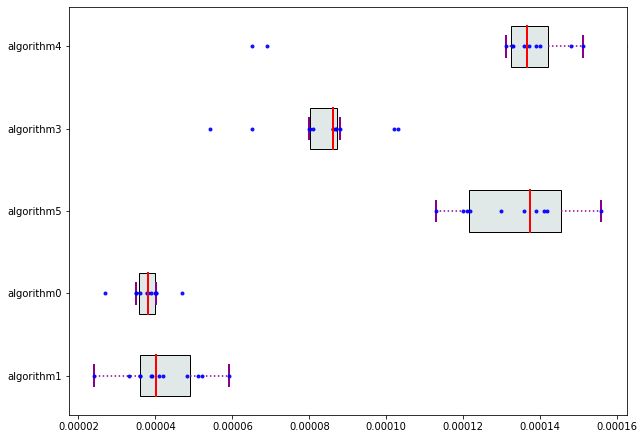

In [37]:
mv.show_measurements_boxplots(outliers=False)

In [32]:
print("Initial Sequence: ", alg_seq_h0)
ranks.merge(mean_ranks.iloc[:,[0,-1]], on='case:concept:name')

Initial Sequence:  ['algorithm1', 'algorithm0', 'algorithm5', 'algorithm3', 'algorithm4']


,case:concept:name,case:rank:q95-q5,case:rank:q90-q10,case:rank:q85-q15,case:rank:q80-q20,case:rank:q75-q25,case:rank:q70-q30,case:rank:q65-q35,case:mean-rank.4
0,algorithm0,0,0,0,0,0,0,0,0.0
1,algorithm1,0,0,0,0,0,0,0,0.0
2,algorithm3,1,1,1,1,1,1,1,1.0
3,algorithm5,2,2,2,2,2,2,2,2.0
4,algorithm4,2,2,2,2,2,2,2,2.0


In [36]:
competing_cases

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration,case:flops,case:num_kernels,case:rel-flops,case:rel-duration
0,algorithm1,1.657005e+09,1.657005e+09,0.000038,270000.0,3,0.000000,0.00000
1,algorithm5,1.657005e+09,1.657005e+09,0.000093,1780000.0,3,5.592593,1.43750
3,algorithm0,1.657005e+09,1.657005e+09,0.000038,270000.0,3,0.000000,0.00000
4,algorithm3,1.657005e+09,1.657005e+09,0.000078,1020000.0,3,2.777778,1.04375
